# imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install slycot
!pip install control
import control as ct
import numpy as np
import matplotlib.pyplot as plt
!pip3 install pysindy
import pysindy as ps
import scipy.stats as stats
from scipy import signal
import traitlets
import sys
import io
from matplotlib.gridspec import GridSpec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/57/d0/7e9b39e64edf24bbbc16b3304ece1d28bac6a25fd7fd7fbdb59e036036a3/slycot-0.5.3.tar.gz#sha256=727d6ed857ea66f72adb4b84c29c45a71beb346127324e245db2aaf01d0df7cd (from https://pypi.org/simple/slycot/) (requires-python:>=3.8): Requested unknown from https://files.pythonhosted.org/packages/57/d0/7e9b39e64edf24bbbc16b3304ece1d28bac6a25fd7fd7fbdb59e036036a3/slycot-0.5.3.tar.gz#sha256=727d6ed857ea66f72adb4b84c29c45a71beb346127324e245db2aaf01d0df7cd has inconsistent name: filename has 'slycot', but metadata has 'unknown'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... don

# fitting functions

In [4]:
def SINDY_delays_3d(shape_factors, scale_factors, loc_factors, t, forcing, response, final_run, poly_degree):

  print(shape_factors)

  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['Q']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 


    feature_names.append(str("P-Trans-" + str(shape_idx + 1)) )
  
  # SINDy
  model = ps.SINDy(
      differentiation_method= ps.SmoothedFiniteDifference(),
      feature_library=ps.PolynomialLibrary(degree=poly_degree,include_bias = False, include_interaction=False), 
      optimizer = ps.STLSQ(threshold=0), 
      feature_names = feature_names
  )

  #U = np.concatenate((np.reshape(forcing,(-1,1)), shapes) , axis=1)
  #if (any(shapes == np.inf)):
  #  print("infinite value in U")
  #U = np.nan_to_num(shapes,nan=0.0, posinf=np.finfo(np.float64).max, neginf=np.finfo(np.float64).min)
  U = shapes
  model.fit(response,t=t,u=U)
  #model.print()
  #print("score = ",model.score(response,t=t,u=U)) # training data score

  mae = 10**6 # placeholder, shows simulation diverged or wasn't final run
  rmse = 10**6
  simulated = np.ones(shape=(len(response[1:]),1))*np.mean(response)
  if (final_run): 
    
    print("number of lines:")
    print(len(shape_factors))
    plt.figure(figsize=(20,10))
    plt.plot(U)
    plt.title("final input transformations")
    plt.show()
    '''
    plt.figure(figsize=(5,5))
    plt.title("input transformation parameters")
    plt.scatter(loc_factors, shape_factors)
    plt.xlabel("location")
    plt.ylabel("shape")
    plt.show()
    '''

    model.print(precision=5)
    print("score = ",model.score(response,t=t,u=U)) # training data score

    try: # in case simulation diverges
      y = np.reshape(response,(-1,1)) # to match simulation results dimension
      simulated = model.simulate([response[1]],t=t,u=U)

      fig, ax1 = plt.subplots(figsize=(20,10))
      ax2 = ax1.twinx()
      plt.title(str("polynomial degree = "+ str(poly_degree)))

      line1 = ax1.plot(t[1:],y[1:],'r-.',label='measured streamflow')
      line2 = ax1.plot(t[1:],simulated[:len(t)-1],'g--',label='simulated streamflow')
      ax1.set_xlabel(r'Time ($min$)')
      ax1.set_ylabel(r'response magnitude')
      ax1.set_ylim([1.2*min(y),1.2*max(y)])

      line3 = ax2.plot(t[1:],forcing[1:],'b',label='rainfall')
      ax2.set_ylabel("rainfall intensity")

      line4 = ax2.plot(t[1:], shapes[1:] * ( np.max(forcing) / np.max(shapes  ) ) , 'k--', label='transformed rainfall', alpha=0.35)
      
      lns = line1+line2+line3+line4
      labs = [l.get_label() for l in lns]
      plt.legend(lns, labs, loc=0,ncol=3,fontsize=20)





      plt.show()
      
      mae = np.mean(np.abs(simulated[:len(t)-1]-y[1:])) # mean absolute error
      print("Simulation MAE = ", mae)
      rmse = np.sqrt(np.mean((simulated[:len(t)-1]-y[1:])**2)) # root mean squared error
      print("Simulation RMSE = ", rmse)


    except:
      print("Simulation diverged.")


    


  return [model.score(response,t=t,u=U), model, mae, rmse, t[1:], simulated[:len(t)-1] , response[1:] , forcing[1:] , U]

# takes np array X and assumes the zeroeth column is the forcing
def optimize_lag_shapes(polyorder, target, init_num_lines, max_num_lines, X,max_iter):
  results = list()

  rates_of_change = abs(np.diff(X[:,target]))
  biggest_movers = np.flip(np.argsort(rates_of_change))
  maxes = np.array([biggest_movers[0]])
  if (maxes[0] < 1):
    maxes[0] = 1 # lower bound shape at 1

  # if a close neighbor is already selected, don't want that to be a starting point
  for index in range(0,len(biggest_movers)):
    if ( (abs(biggest_movers[index] - maxes) > int(len(X) / 1000*init_num_lines)).all()   ): 
      # more than some fraction of the total length apart
      # using init_num_lines strikes a balance between starting evenly spaced 
      # and starting all clustered on the steep regions
      if (biggest_movers[index] < 1):
        maxes = np.append(maxes,1) 
      else:
        maxes = np.append(maxes,float(biggest_movers[index]))
    if (len(maxes) >= max_num_lines):
      break

  previous_best = 0

  shape_factors = np.array([])
  scale_factors = np.array([])
  loc_factors = np.array([])
  speeds =  list([200,50,10, 5,2, 1.1, 1.05, 1.01, 1.001, 1.0001,1.00001]) 
  
  for num_lines in range(init_num_lines,max_num_lines):
    #print(num_lines)
    #speed = 6.4 # how far we'll jump around initially
    speed_idx = 0
    speed = speeds[speed_idx]

    if (len(shape_factors) == 0):  # if we're starting right now
      # start sharp
      #loc_factors = maxes[0:init_num_lines]
      #scale_factors = np.ones(len(loc_factors))
      #shape_factors = np.ones(len(scale_factors))

      # start dull
      shape_factors = maxes[0:init_num_lines]
      scale_factors = np.ones(shape = shape_factors.shape)
      loc_factors = np.ones(shape = shape_factors.shape)

      
    else:
      # start dull
      sharp_cand = maxes[num_lines]
      delay_cand = 1
      loc_cand = 1

      # start sharp
      #delay_cand = 1
      #sharp_cand = 1
      #loc_cand = biggest_movers[-num_lines*3]
      shape_factors = np.append(shape_factors, sharp_cand)
      scale_factors = np.append(scale_factors, delay_cand)
      loc_factors = np.append(loc_factors, loc_cand)

    # changed prev model to true for verbose output
    prev_model = SINDY_delays_3d(shape_factors, scale_factors, loc_factors, np.arange(0,len(X)), X[:,0], X[:,target],False, polyorder )

    print("\nInitial model:\n")
    print("score")
    print(prev_model[0])
    print("shape factors")
    print(shape_factors)
    print("scale factors")
    print(scale_factors)
    print("location factors")
    print(loc_factors)
    print("")

    for iterations in range(0,max_iter ):
      tuning_line = iterations % num_lines

      sooner_locs = np.array(loc_factors)
      sooner_locs[tuning_line-1] = float(loc_factors[tuning_line-1] - speed*len(X)/10**4  )
      if ( sooner_locs[tuning_line-1] < 0):
        sooner = np.zeros(len(prev_model))
      else:
        sooner = SINDY_delays_3d(shape_factors ,scale_factors ,sooner_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      
      later_locs = np.array(loc_factors)
      later_locs[tuning_line-1] = float ( loc_factors[tuning_line-1]  +   1.01*speed*len(X)/10**4 )
      later = SINDY_delays_3d(shape_factors , scale_factors,later_locs, 
          np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      

      shape_up = np.array(shape_factors)
      shape_up[tuning_line-1] = float ( shape_factors[tuning_line-1]*speed*1.01 )
      shape_upped = SINDY_delays_3d(shape_up , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      shape_down = np.array(shape_factors)
      shape_down[tuning_line-1] = float ( shape_factors[tuning_line-1]/speed )
      if (shape_down[tuning_line-1] < 1):
        shape_downed = np.zeros(len(prev_model)) # return a score of zero as this is illegal
      else:
        shape_downed = SINDY_delays_3d(shape_down , scale_factors, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )

      scale_up = np.array(scale_factors)
      scale_up[tuning_line-1] = float(  scale_factors[tuning_line-1]*speed*1.01 )
      scaled_up = SINDY_delays_3d(shape_factors , scale_up, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


      scale_down = np.array(scale_factors)
      scale_down[tuning_line-1] = float ( scale_factors[tuning_line-1]/speed )
      scaled_down = SINDY_delays_3d(shape_factors , scale_down, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )
      
      # rounder
      rounder_shape = np.array(shape_factors)
      rounder_shape[tuning_line-1] = shape_factors[tuning_line-1]*(speed*1.01)
      rounder_scale = np.array(scale_factors)
      rounder_scale[tuning_line-1] = scale_factors[tuning_line-1]/(speed*1.01)
      rounder = SINDY_delays_3d(rounder_shape , rounder_scale, loc_factors, 
                                np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )

      # sharper
      sharper_shape = np.array(shape_factors)
      sharper_shape[tuning_line-1] = shape_factors[tuning_line-1]/speed
      if (sharper_shape[tuning_line -1] < 1):
        sharper = np.zeros(len(prev_model)) # lower bound on shape to avoid inf
      else:
        sharper_scale = np.array(scale_factors)
        sharper_scale[tuning_line-1] = scale_factors[tuning_line-1]*speed
        sharper = SINDY_delays_3d(sharper_shape ,sharper_scale,loc_factors, 
                                  np.arange(0,len(X)), X[:,0], X[:,target], False, polyorder )


    

      scores = [prev_model[0], shape_upped[0], shape_downed[0], scaled_up[0], scaled_down[0], sooner[0], later[0], rounder[0], sharper[0] ]
      #print(scores)
      if (sooner[0] >= max(scores)):
        prev_model = sooner
        loc_factors = sooner_locs
      elif (later[0] >= max(scores)):
        prev_model = later
        loc_factors = later_locs

      elif(shape_upped[0] >= max(scores)):
        prev_model = shape_upped
        shape_factors = shape_up
      elif(shape_downed[0] >=max(scores)):
        prev_model = shape_downed
        shape_factors = shape_down

      elif(scaled_up[0] >= max(scores)):
        prev_model = scaled_up
        scale_factors = scale_up
      elif(scaled_down[0] >= max(scores)):
        prev_model = scaled_down
        scale_factors = scale_down


      elif (rounder[0] >= max(scores)):
        prev_model = rounder
        shape_factors = np.array(rounder_shape)
        scale_factors = np.array(rounder_scale)
      elif (sharper[0] >= max(scores)):
        prev_model = sharper
        shape_factors = np.array(sharper_shape)
        scale_factors = np.array(sharper_scale)


      elif( (num_lines - 1) == tuning_line): # the middle was best, but it's bad, tighten up the bounds (if we're at the last tuning line)
        
        speed_idx = speed_idx + 1
        
        if (speed_idx >= len(speeds)):
          break
        speed = speeds[speed_idx]
        
        '''
        if (speed > 10):
          speed = speed*0.5 # coarse tuning
          
        elif(speed > 1.3):
          speed = speed*0.8 # fine tuning
        else:
          speed = speed*0.95 # very fine tuning
        '''
        print("\nprevious, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper")
        print(scores)
        print("speed")
        print(speed)
        print("shape factors")
        print(shape_factors)
        print("scale factors")
        print(scale_factors)
        print("location factors")
        print(loc_factors)
        print("iteration no:")
        print(iterations)
        print("\n")
        
        #print(scores)
        if (speed < 1):
          print("converged, max accuracy for number of lines")
          break
    
    
    final_model = SINDY_delays_3d(shape_factors, scale_factors ,loc_factors,np.arange(0,len(X)), X[:,0], X[:,target], True, polyorder )
    results.append([final_model, shape_factors, scale_factors, loc_factors])
    if ((previous_best and final_model[0] - previous_best[0] < 0.005) or ( previous_best and final_model[0] - previous_best[0] < 0.01 and final_model[2] > previous_best[2] )): 
      # marginal (less than half percent improvement) OR somewhat marginal improvement in fit and worse mae
      break # we can be done
    else:
      previous_best = final_model
  winning_model = None
  best_mae = np.Inf
  for num_lines in range(len(results)):
    if (results[num_lines][0][2] < best_mae):
      winning_model = results[num_lines]
      best_mae = results[num_lines][0][2]

  return winning_model
    
def transform_input(shape_factors, scale_factors, loc_factors,t, forcing):
  shape_time = np.arange(0,len(t),1) # analogous to drainage_time
  # shapes is analogous to "drainage" in original code
  feature_names=['response']# , 'forcing']
  shapes = np.zeros(shape=(len(t), len(shape_factors)))
  for shape_idx in range(0,len(shape_factors)):
    for idx in range(0,len(t)):
      if (abs(forcing[idx]) > 10**-6): # when nonzero forcing occurs
        if (idx == int(0)):

          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time, shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

        else:
          shapes[idx:,shape_idx] = shapes[idx:,shape_idx] + forcing[idx]*stats.gamma.pdf(shape_time[:-idx], shape_factors[shape_idx], scale=scale_factors[shape_idx], loc = loc_factors[shape_idx]) 

  return shapes 


# generate nash cascade

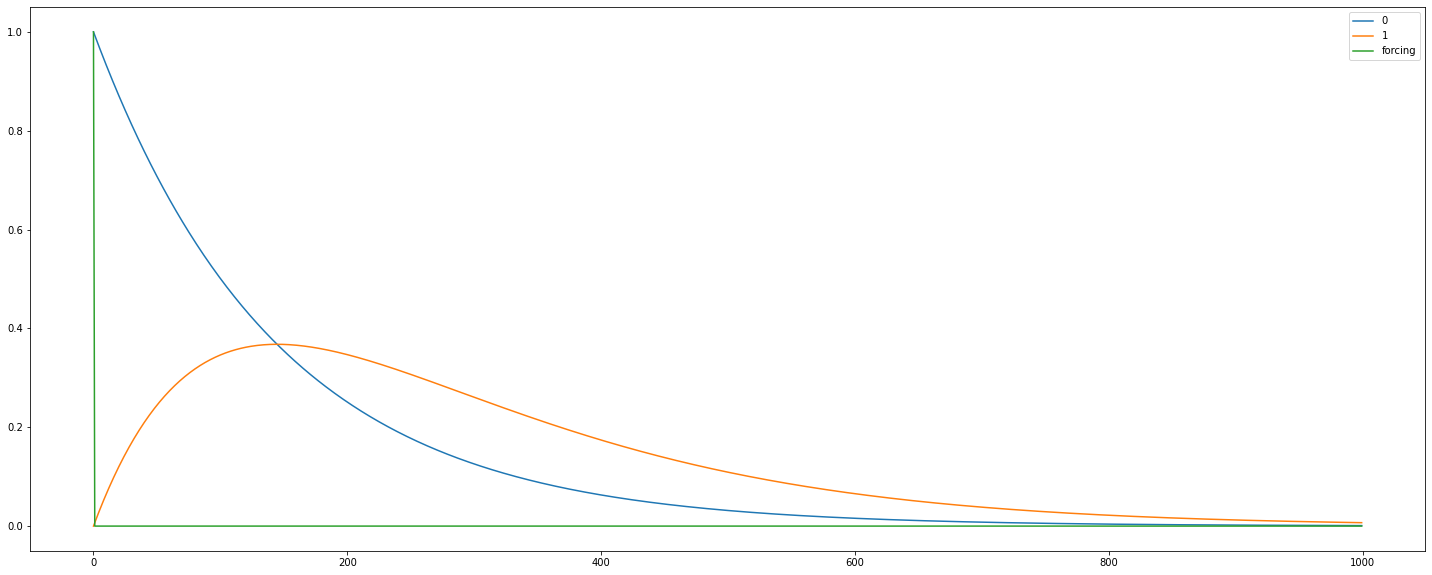

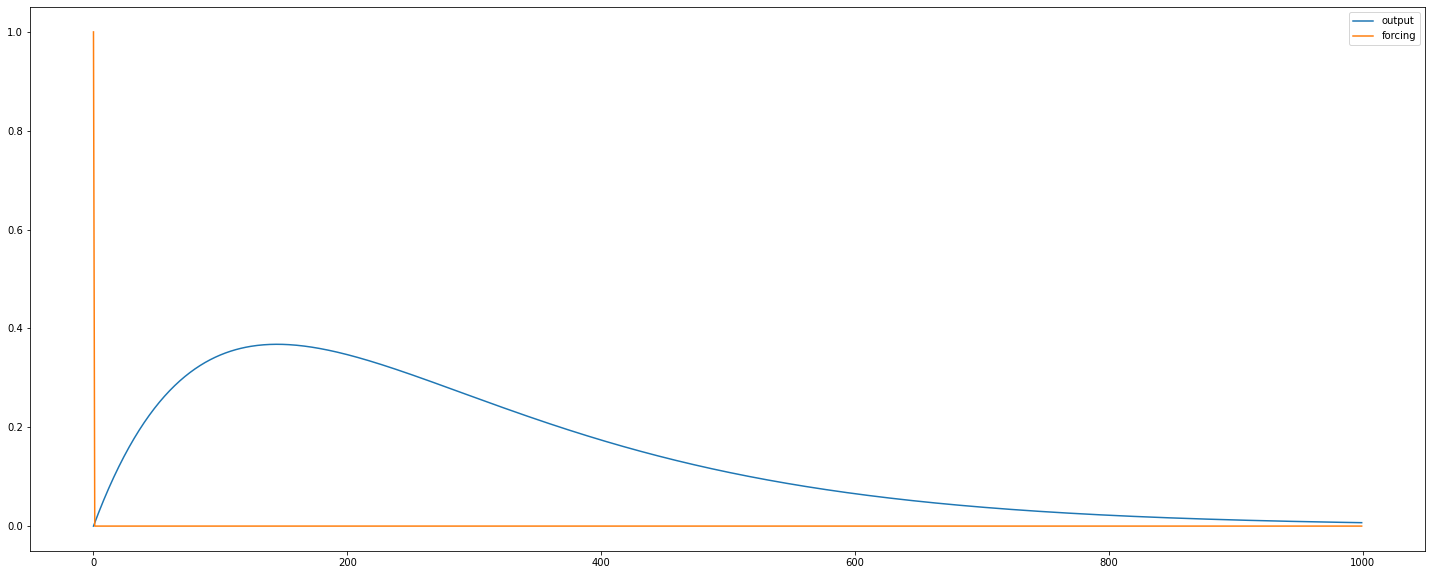

In [5]:
# try with just two states
A = [[-1, 0], [1, -1]]
#A = [[0,-1], [1,0]]
B = [[1],[0]]
C = np.eye(2)
D = np.zeros(shape=(2,1))
cascading_system = ct.ss(A,B,C,D)


response = ct.impulse_response(cascading_system,T_num=1000)
forcing = np.zeros(len(response.time))
forcing[0] = np.max(response.outputs)
plt.figure(figsize=(25,10))
for state in range(2):
  plt.plot(response.outputs[state][0], label=str(state))

plt.plot(forcing, label='forcing')
plt.legend()
# now, assume we can't see state 0, but only the forcing and the response
plt.figure(figsize=(25,10))
plt.plot(response.outputs[1][0], label='output')
plt.plot(forcing, label='forcing')
plt.legend()
X = np.concatenate((np.reshape(forcing,(-1,1)),np.reshape(response.outputs[1][0] , (-1,1) )),axis=1)


[1.]

Initial model:

score
0.05645240349868408
shape factors
[1.]
scale factors
[1.]
location factors
[1.]

[1.]
[202.]
[1.]
[1.]
[202.]
[1.]
number of lines:
1


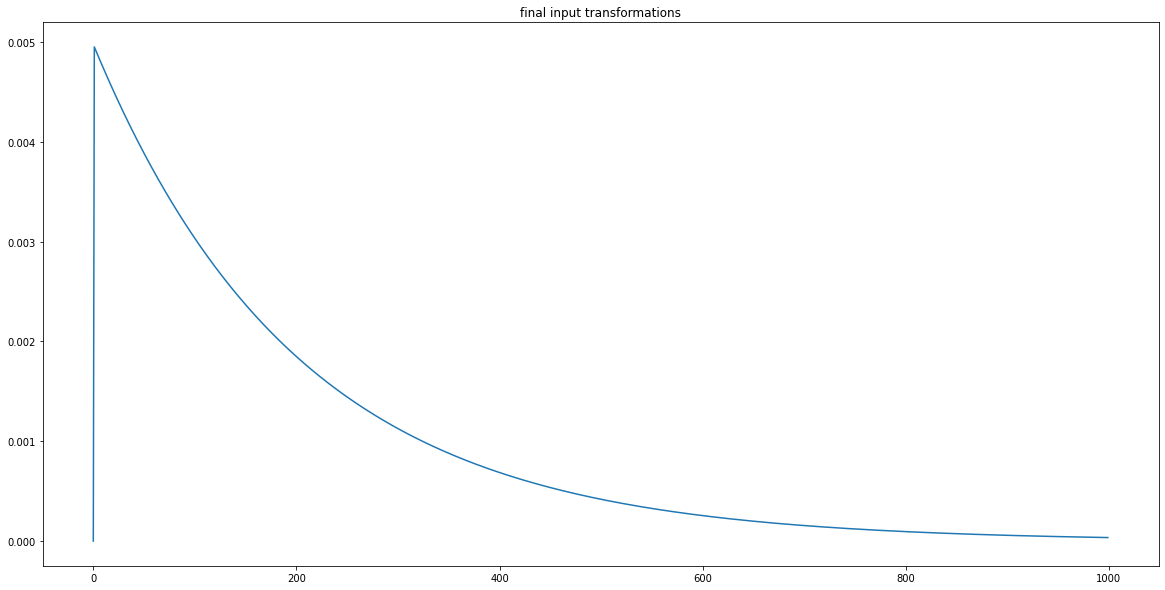

(Q)' = -0.00964 Q + 1.42641 P-Trans-1
score =  0.9705915941791338


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


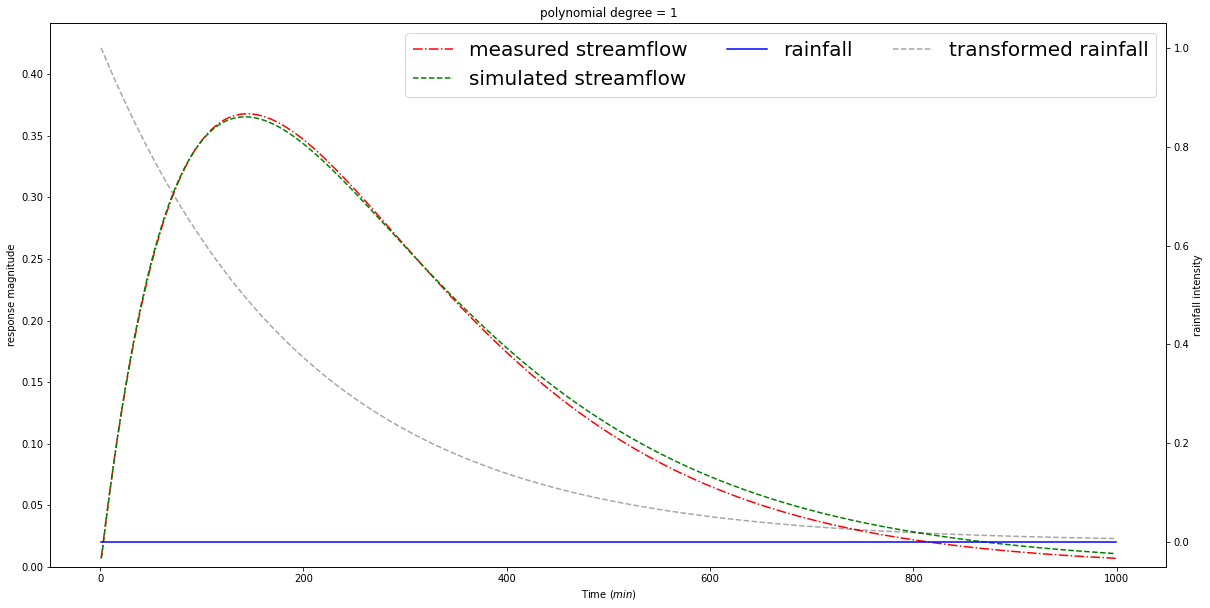

Simulation MAE =  0.004526139309697092
Simulation RMSE =  0.005151843235973607


In [6]:
iterations = 1
best_model = optimize_lag_shapes(1,1,1,2,X,iterations)

# generate figure
1: a 4 panel showing the estimated state, actual latent state, sindy simulation, and actual output state 
(with the model score and equation as an annotation on the graph)
(consult paper1-rough version 2 for a mockup)


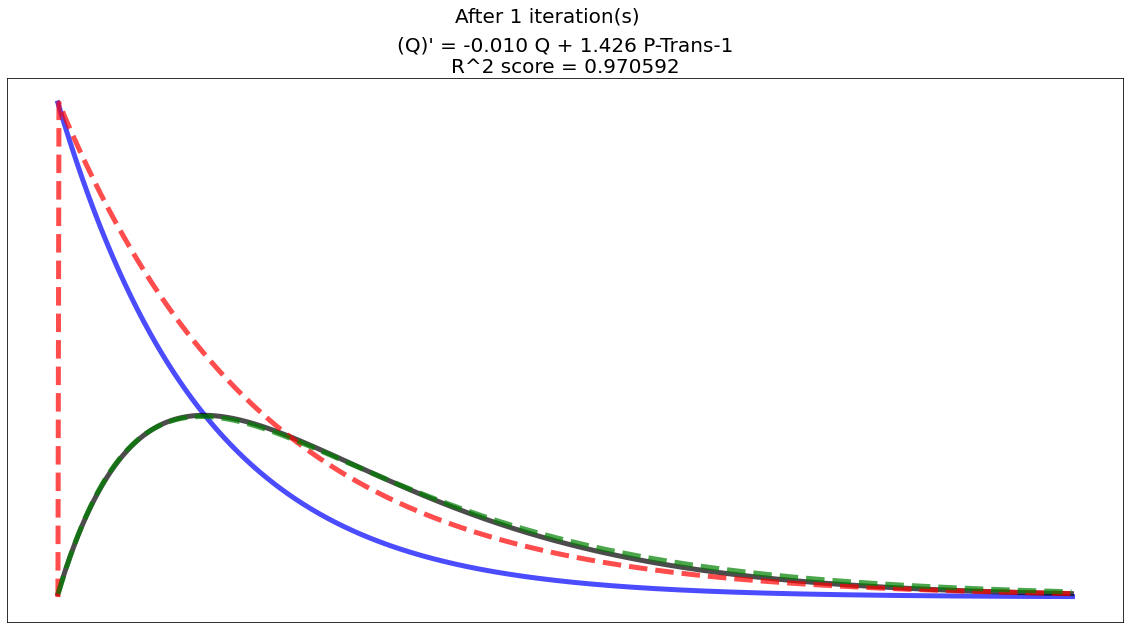

In [7]:
import traitlets
import sys
import io
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

best_model[0][1].print(precision=3)
# print goes stragith to stdout so all this monkery is necessary to grab it as a string
title = new_stdout.getvalue()

sys.stdout = old_stdout
# to print normally again

title = str(title + "R^2 score = %f" % best_model[0][0])


scaled_forcing = best_model[0][-1]
scaled_forcing[:] = scaled_forcing[:] * np.max(response.outputs[0][0]) / np.max(scaled_forcing[:])

plt.figure(figsize=(20,10))
plt.plot(response.outputs[0][0], 'b-', label = "actual first reservoir",linewidth=5,alpha=0.7)
plt.plot(best_model[0][-3], 'k-', label="actual second reservoir",linewidth=5,alpha=0.7)
plt.plot(scaled_forcing, 'r--', label = "estimated first reservoir",linewidth=5,alpha=0.7)
plt.plot(best_model[0][-4], 'g--', label="simulated second reservoir",linewidth=5,alpha=0.7)

plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    left=False) # labels along the bottom edge are off

#subt = str(print(best_model[0][1]))
    #model.print(precision=5)
    #print("score = ",model.score(response,t=t,u=U)) # training data score

plt.title(title,fontsize=20)
plt.suptitle('After %d iteration(s)' % iterations, fontsize=20)
if (iterations < 1):
  plt.legend(fontsize=30)
# return [model.score(response,t=t,u=U), model, mae, rmse, t[1:], simulated[:len(t)-1] , response[1:] , forcing[1:] , U]



# recover multiple parallel reservoirs exactly

Text(0.5, 1.0, 'Watershed as Parallel Reservoir Network')

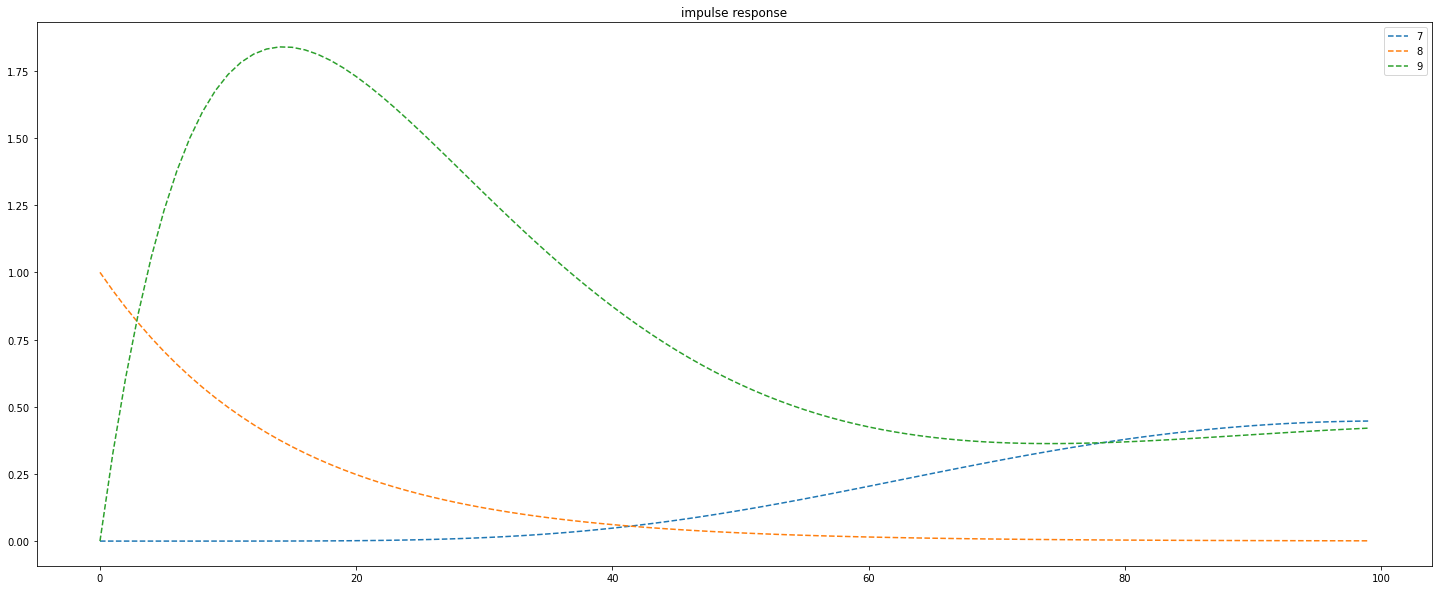

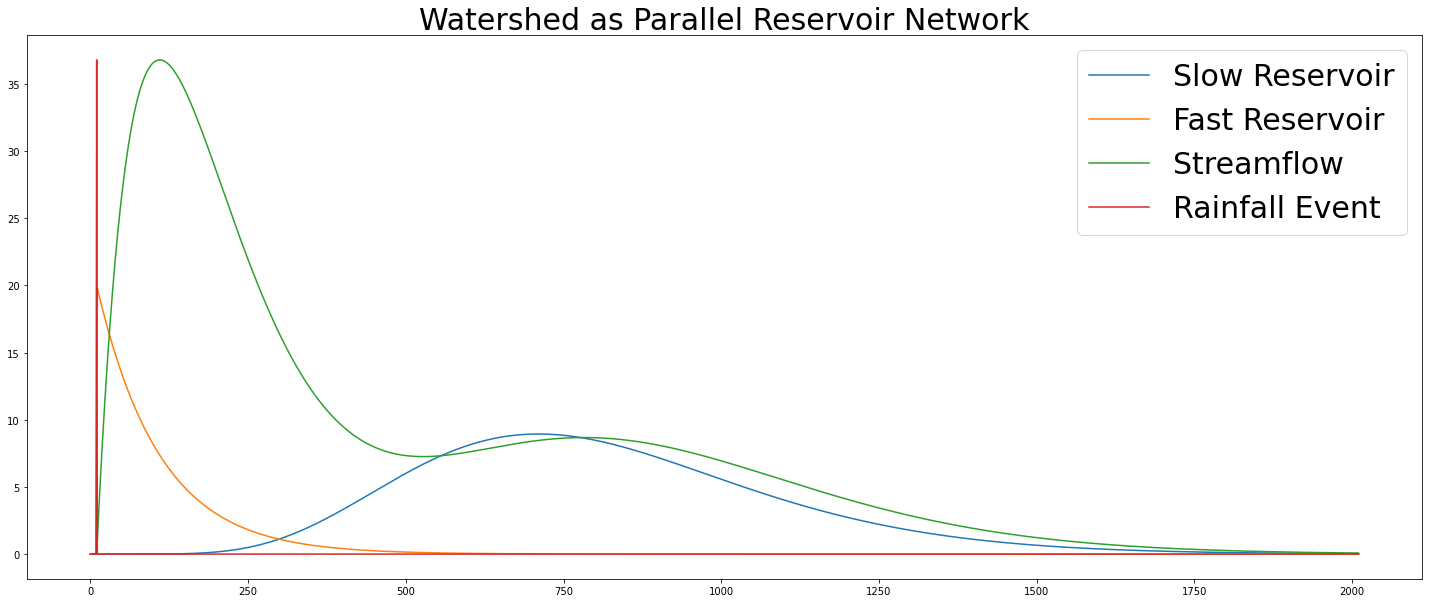

In [8]:
A = np.diag(-.01*np.ones(10))

# define cascade connections
A[1,0] = .01
A[2,1] = .01
A[3,2] = .01
A[4,3] = .01
A[5,4] = .01 # two reservoirs
A[6,5] = .01
A[7,6] = .01

# define connections to output
#A[9,4] = .01
A[9,7] = .01
#A[9,8] = .01
A[9,8] = 0.05

# define input 
B = np.zeros(shape=(10,1))
B[0]= 3
#B[5] = 2
B[8] = 1

C = np.eye(10)
D = np.zeros(shape=(10,1))

parallel_reservoirs = ct.ss(A,B,C,D)

response = ct.impulse_response(parallel_reservoirs)
plt.figure(figsize=(25,10))
states_to_plot = np.array([7,8,9])
for state in states_to_plot:
  plt.plot(response.outputs[state][0], '--', label=str(state))

plt.legend()
plt.title("impulse response")


u = np.concatenate((np.zeros(10), 20*np.ones(1), np.zeros(2000)))
response = ct.forced_response(parallel_reservoirs,np.arange(0,len(u)),u)


plt.figure(figsize=(25,10))
for state in states_to_plot:
  plt.plot(response.outputs[state][:], label=str(state))

plt.plot(u*np.max(response.outputs[9][:]) / np.max(u), label='forcing (scaled)')
plt.legend(["Slow Reservoir","Fast Reservoir","Streamflow","Rainfall Event"], fontsize=30)
plt.title("Watershed as Parallel Reservoir Network",fontsize=30)

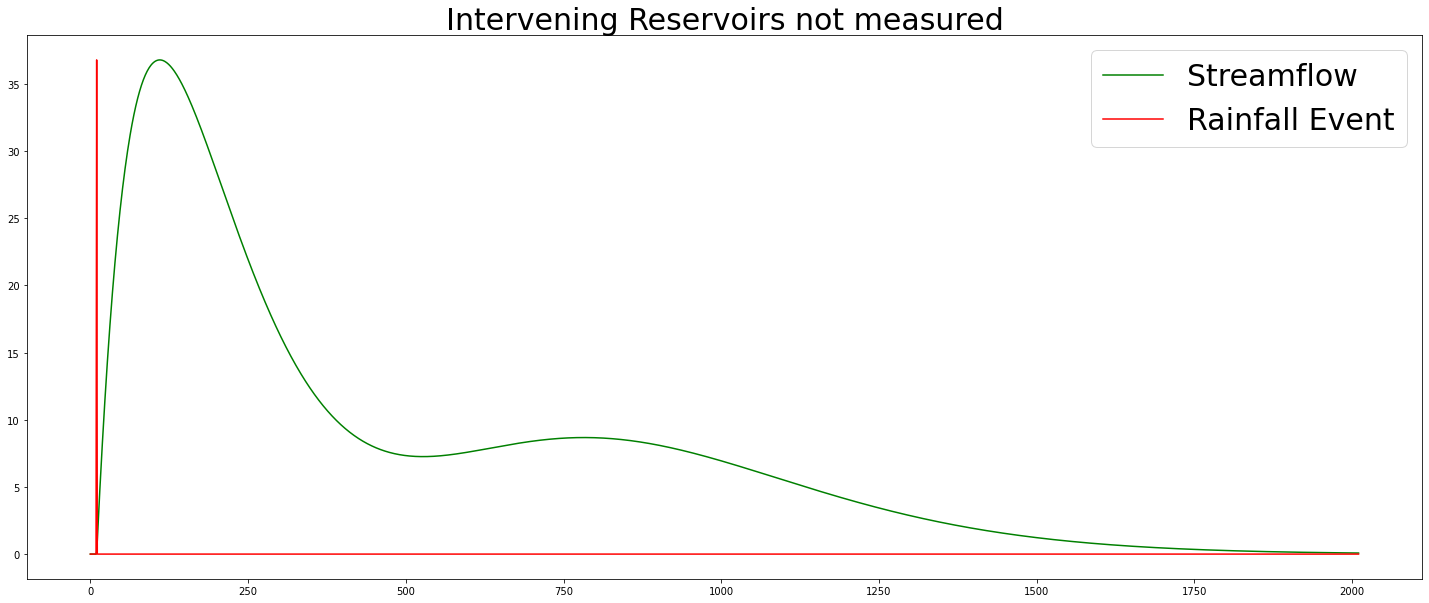

In [9]:
plt.figure(figsize=(25,10))
plt.plot(response.outputs[9][:], 'g',label='output')
plt.plot(u*np.max(abs(response.outputs[9][:])) / np.max(abs(u)), 'r',label='forcing (scaled)')
plt.legend(["Streamflow","Rainfall Event"],fontsize=30)
plt.title("Intervening Reservoirs not measured", fontsize=30)
X = np.concatenate((np.reshape(u,(-1,1)),np.reshape(response.outputs[9][:] , (-1,1) )),axis=1)


[11.]

Initial model:

score
0.2909522707521295
shape factors
[11.]
scale factors
[1.]
location factors
[1.]

[11.]
[2222.]
[11.]
[11.]
[2222.]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, -9.009022372552522e-08, 0.0, 0.0007645232543080915, -2.6244480522130686e-07, 0.0, 0.038743037456490104, 0.0254273548114351, 0.0]
speed
50
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
0


[11.]
[555.5]
[11.]
[11.]
[555.5]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, 8.631454986052223e-05, 0.0, 0.005957696743443375, 0.02900603663343504, 0.0, 0.18715028573155335, 0.03592172641410163, 0.0]
speed
10
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
1


[11.]
[111.1]
[1.1]
[11.]
[11.]
[111.1]
[1.1]
[1.1]
[11.11]
[1.1]
[1.1]
[11.11]
[1.1]
[11.11]
[1.1]
[1.1]
[11.11]

previous, shape up, shape down, scale up, scale down, sooner, l

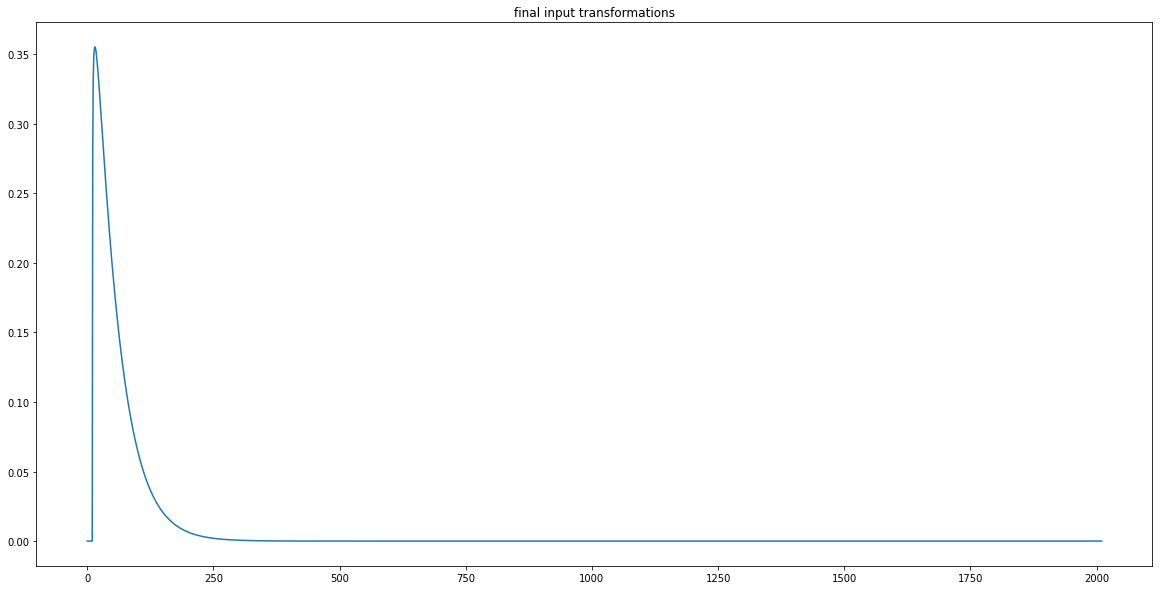

(Q)' = -0.00388 Q + 2.54608 P-Trans-1
score =  0.9499961431349364


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


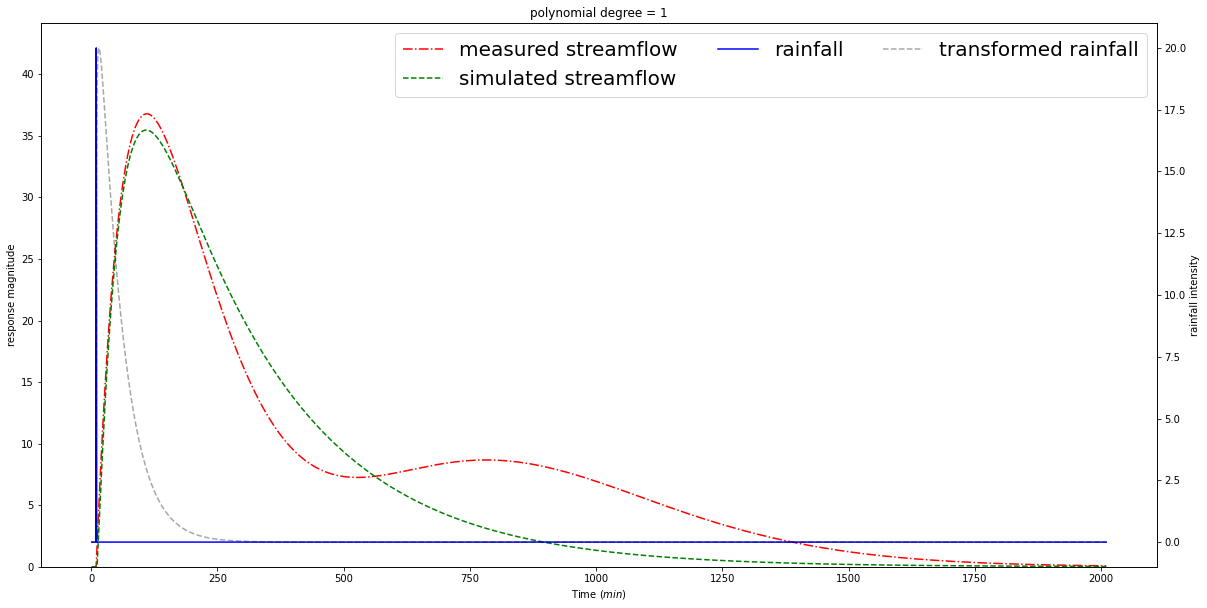

Simulation MAE =  2.471760816231067
Simulation RMSE =  3.181484668025565
[ 1.10878133 17.        ]

Initial model:

score
0.9506880796395217
shape factors
[ 1.10878133 17.        ]
scale factors
[41.82823634  1.        ]
location factors
[0.8212221 1.       ]

[ 1.10878133 17.        ]
[1.10878133e+00 3.43400000e+03]
[ 1.10878133 17.        ]
[ 1.10878133 17.        ]
[1.10878133e+00 3.43400000e+03]
[ 1.10878133 17.        ]
[223.97382837  17.        ]
[ 1.10878133 17.        ]
[ 1.10878133 17.        ]
[223.97382837  17.        ]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9506880796395217, 0.28428699199313034, 0.0, 0.2867538929947725, 0.3037979838225281, 0.0, 0.39418308798392976, 0.3404860597215167, 0.0]
speed
50
shape factors
[ 1.10878133 17.        ]
scale factors
[41.82823634  1.        ]
location factors
[0.8212221 1.       ]
iteration no:
1


[ 1.10878133 17.        ]
[  1.10878133 858.5       ]
[ 1.10878133 17.        ]
[ 1.10878133

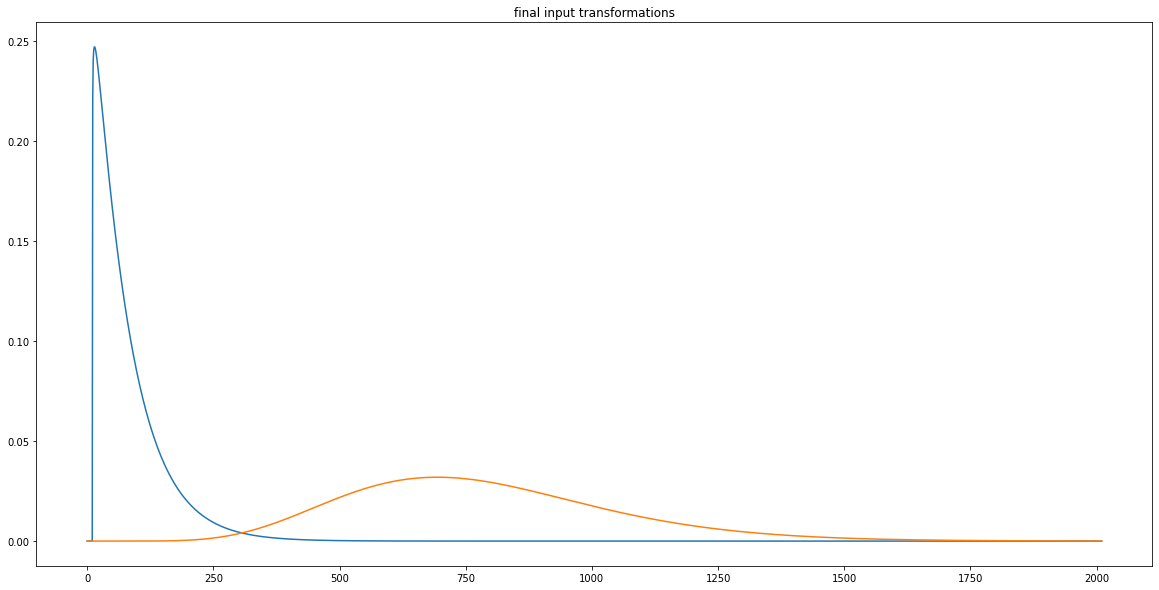

(Q)' = -0.00722 Q + 3.64255 P-Trans-1 + 2.08829 P-Trans-2
score =  0.9832838628698337


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


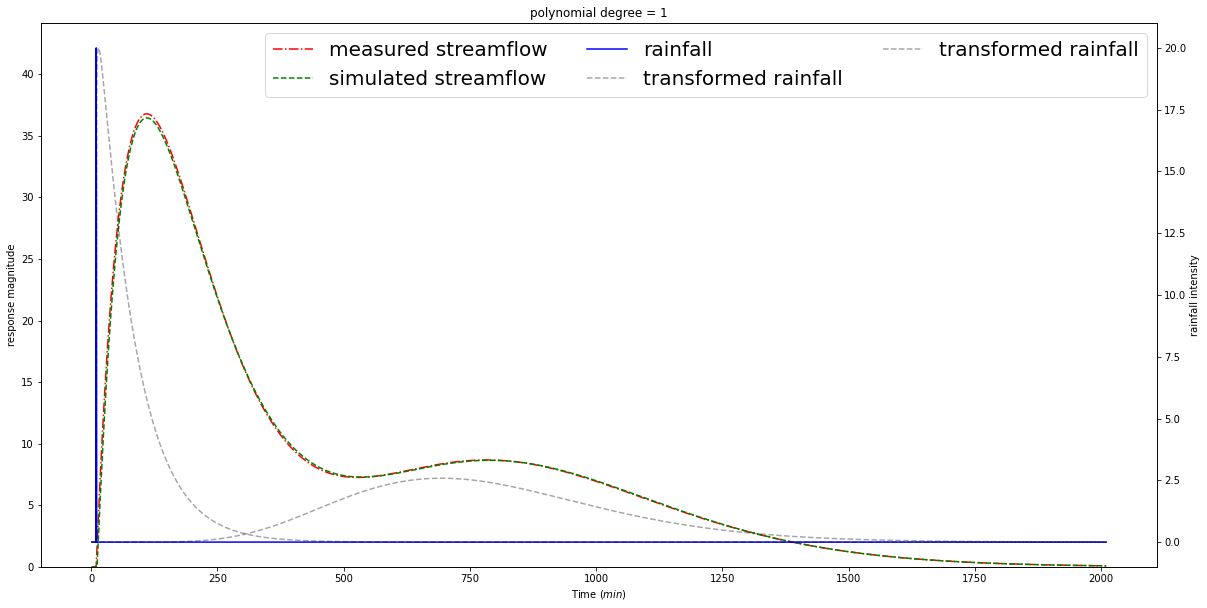

Simulation MAE =  0.09482468048392446
Simulation RMSE =  0.244303476058104


In [10]:
### old version
# iter: 1, num_lines: 1
# iter: 25, num_lines: 1
# iter:10, num_lines: 2
# iter:40, num_lines:2

iterations_per_line = 40
num_lines = 2
best_model = optimize_lag_shapes(1,1,1,num_lines+1,X,iterations_per_line)

old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

best_model[0][1].print(precision=4)
# print goes stragith to stdout so all this monkery is necessary to grab it as a string
title = new_stdout.getvalue().rstrip()

sys.stdout = old_stdout
# to print normally again

title = ' | '.join([title , "R^2 = {score:.3f}".format(score=best_model[0][0]) ])




time = best_model[0][-5]
actual_rainfall = best_model[0][-2]
transformed_rainfall = best_model[0][-1]
modeled_streamflow = best_model[0][-4]


for idx in range(1, len(best_model[0][1].coefficients()[0])):

  transformed_rainfall[:,idx-1] = transformed_rainfall[:,idx-1]  / np.max(transformed_rainfall[:,idx-1]) # magnitude of 1


scaled_response = response.outputs[:]

[11.]

Initial model:

score
0.2909522707521295
shape factors
[11.]
scale factors
[1.]
location factors
[1.]

[11.]
[2222.]
[11.]
[11.]
[2222.]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, -9.009022372552522e-08, 0.0, 0.0007645232543080915, -2.6244480522130686e-07, 0.0, 0.038743037456490104, 0.0254273548114351, 0.0]
speed
50
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
0


[11.]
number of lines:
1


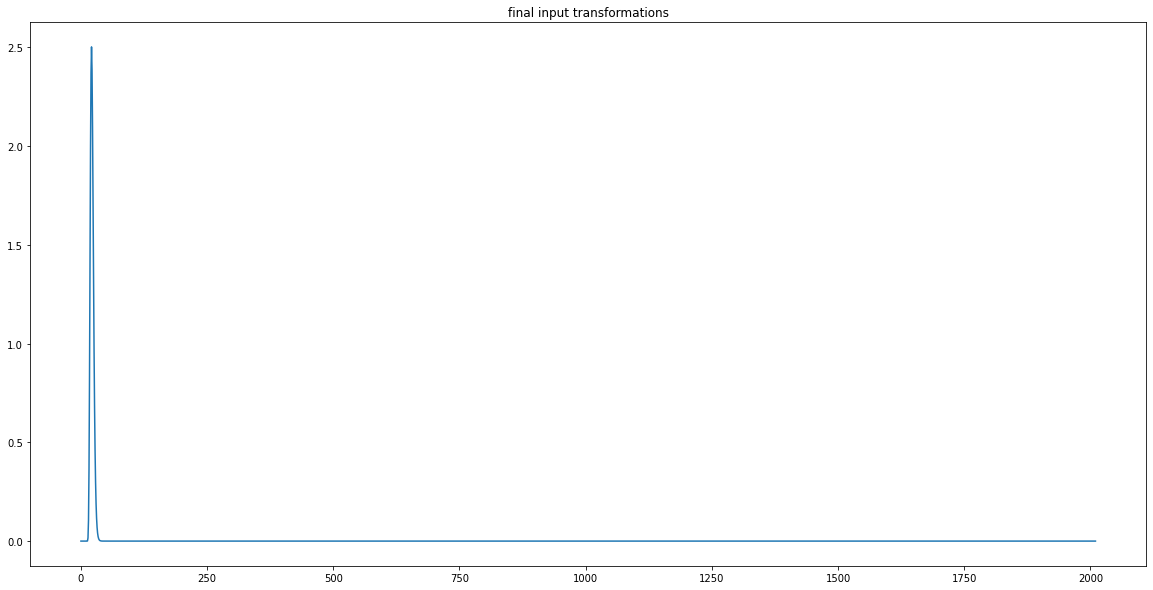

(Q)' = -0.00032 Q + 0.44592 P-Trans-1
score =  0.2909522707521295


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


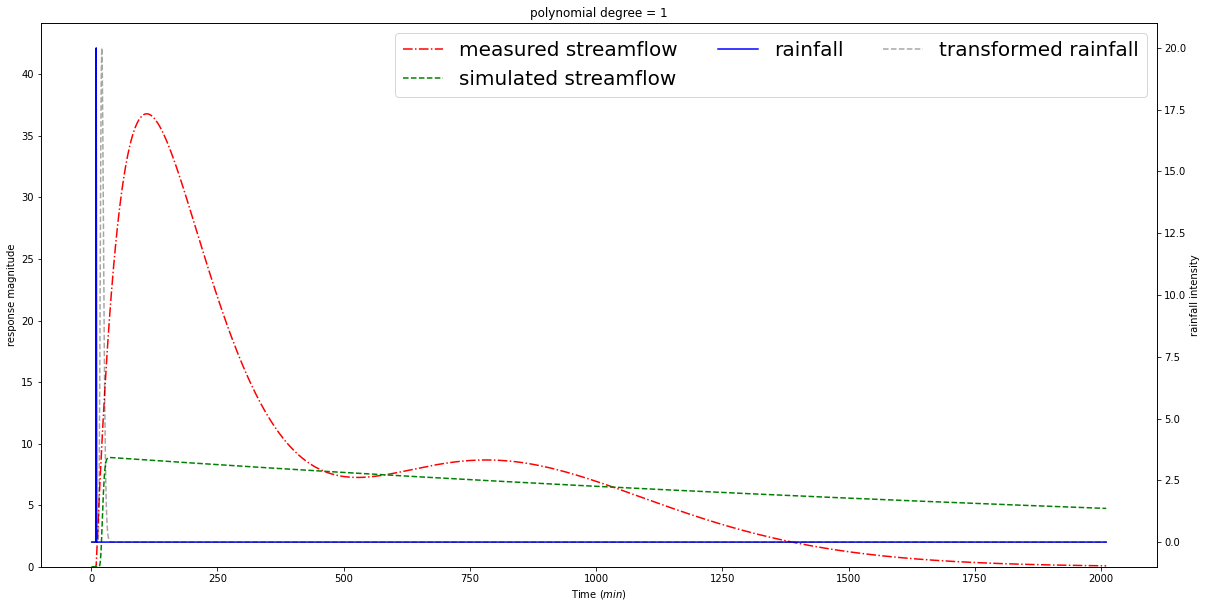

Simulation MAE =  5.025355691085193
Simulation RMSE =  8.277864099970452
[11.]

Initial model:

score
0.2909522707521295
shape factors
[11.]
scale factors
[1.]
location factors
[1.]

[11.]
[2222.]
[11.]
[11.]
[2222.]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, -9.009022372552522e-08, 0.0, 0.0007645232543080915, -2.6244480522130686e-07, 0.0, 0.038743037456490104, 0.0254273548114351, 0.0]
speed
50
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
0


[11.]
[555.5]
[11.]
[11.]
[555.5]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, 8.631454986052223e-05, 0.0, 0.005957696743443375, 0.02900603663343504, 0.0, 0.18715028573155335, 0.03592172641410163, 0.0]
speed
10
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
1


[11.]
[111.1]
[1.1]
[11.]
[11.]
[111.1]
[1.1]
[1.1]
[11.11]
[1.1]
[1.1]
[11.11]
[1.1]
[11.11]
[1.1]
[1.1]

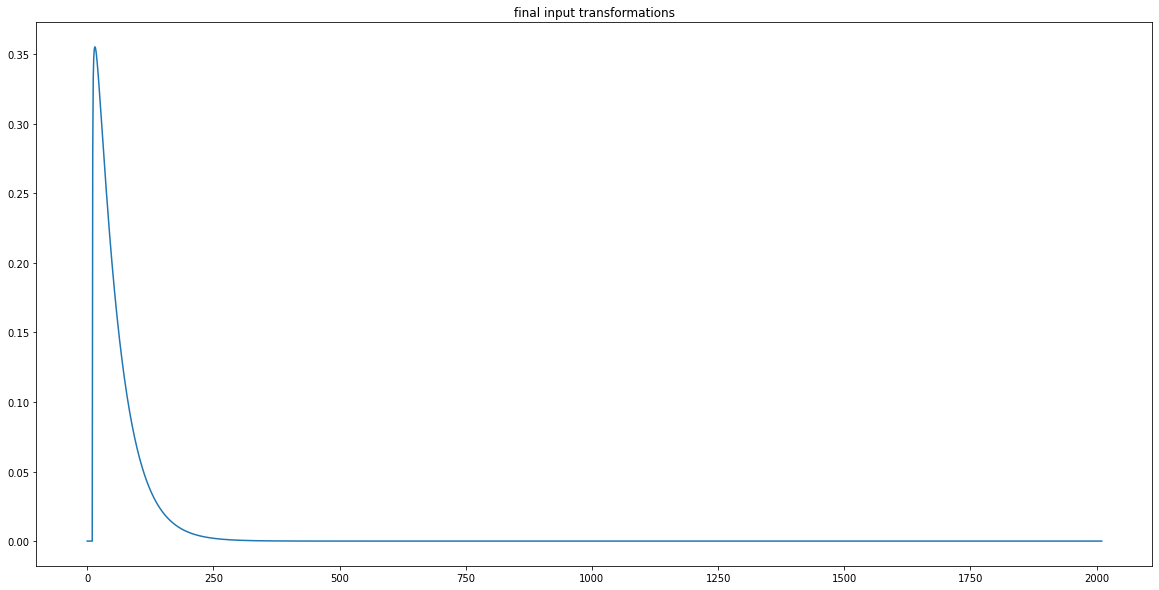

(Q)' = -0.00389 Q + 2.54625 P-Trans-1
score =  0.9499961425728622


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


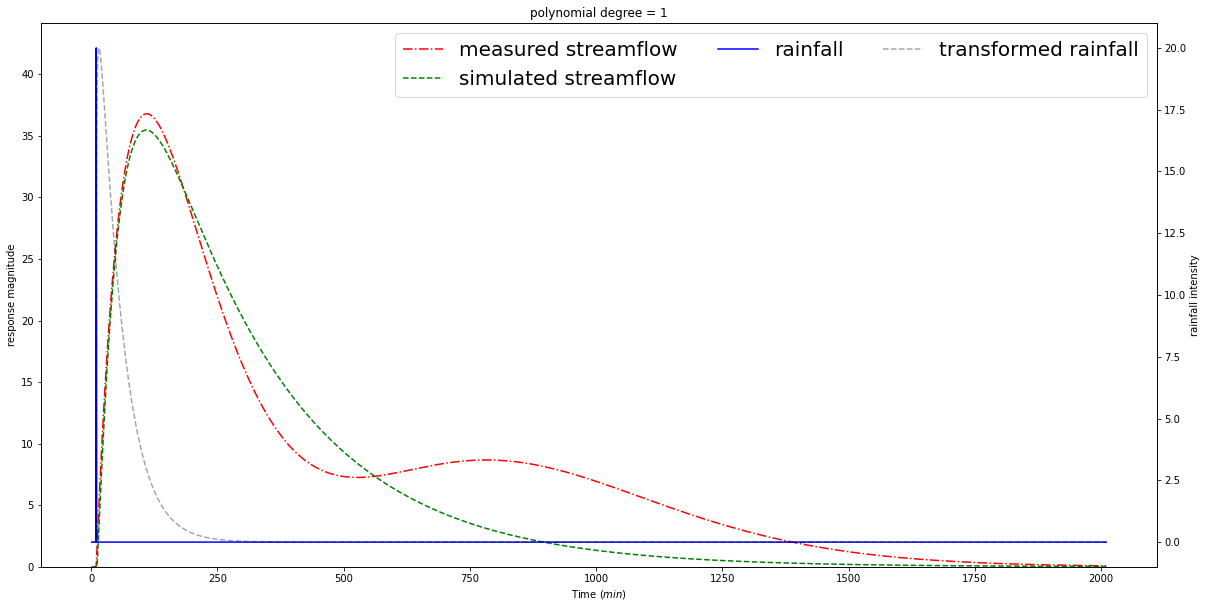

Simulation MAE =  2.471862210718652
Simulation RMSE =  3.1816459221133377
[11.]

Initial model:

score
0.2909522707521295
shape factors
[11.]
scale factors
[1.]
location factors
[1.]

[11.]
[2222.]
[11.]
[11.]
[2222.]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, -9.009022372552522e-08, 0.0, 0.0007645232543080915, -2.6244480522130686e-07, 0.0, 0.038743037456490104, 0.0254273548114351, 0.0]
speed
50
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
0


[11.]
[555.5]
[11.]
[11.]
[555.5]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, 8.631454986052223e-05, 0.0, 0.005957696743443375, 0.02900603663343504, 0.0, 0.18715028573155335, 0.03592172641410163, 0.0]
speed
10
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
1


[11.]
[111.1]
[1.1]
[11.]
[11.]
[111.1]
[1.1]
[1.1]
[11.11]
[1.1]
[1.1]
[11.11]
[1.1]
[11.11]
[1.1]
[1.1

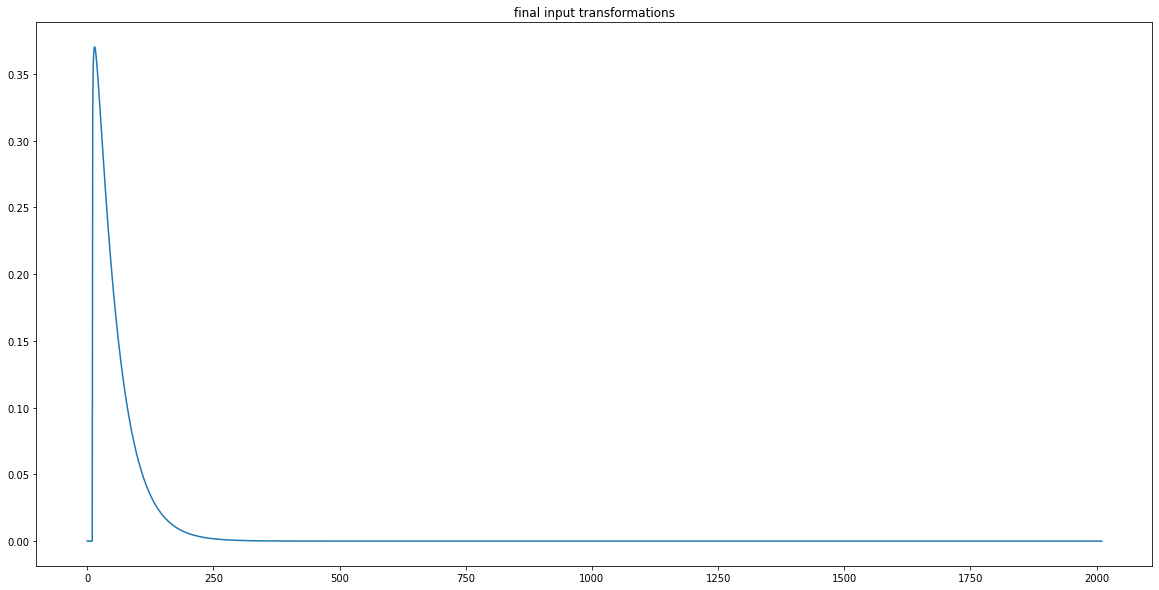

(Q)' = -0.00373 Q + 2.48752 P-Trans-1
score =  0.9490989178463336


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


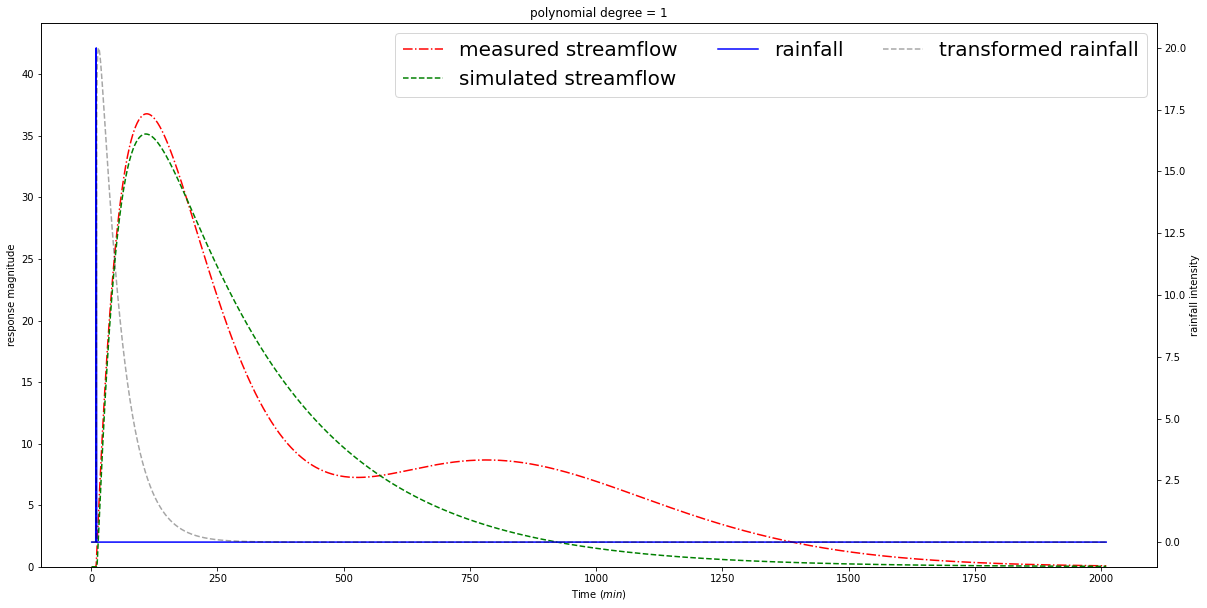

Simulation MAE =  2.435694800331417
Simulation RMSE =  3.1216459188562538
[ 1.1 17. ]

Initial model:

score
0.9496945165480579
shape factors
[ 1.1 17. ]
scale factors
[40.804  1.   ]
location factors
[0.5978 1.    ]

[ 1.1 17. ]
[1.100e+00 3.434e+03]
[ 1.1 17. ]
[ 1.1 17. ]
[1.100e+00 3.434e+03]
[ 1.1 17. ]
[222.2  17. ]
[ 1.1 17. ]
[ 1.1 17. ]
[222.2  17. ]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9497243087932451, 0.0336319280994134, 0.0, 0.03455696698030031, 0.05304662049799336, 0.0, 0.0871850444598864, 0.09014047649615231, 0.0]
speed
50
shape factors
[ 1.1 17. ]
scale factors
[40.804  1.   ]
location factors
[ 0.5978 41.6222]
iteration no:
1


[ 1.1 17. ]
[ 1.1 17. ]
[  1.1 858.5]
[ 1.1 17. ]
[ 1.1 17. ]
[  1.1 858.5]
[ 1.1 17. ]
[55.55 17.  ]
[ 1.1 17. ]
[ 1.1 17. ]
[55.55 17.  ]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9638892254440656, 0.0012759319480435405, 0.0, 0.0013726076432870

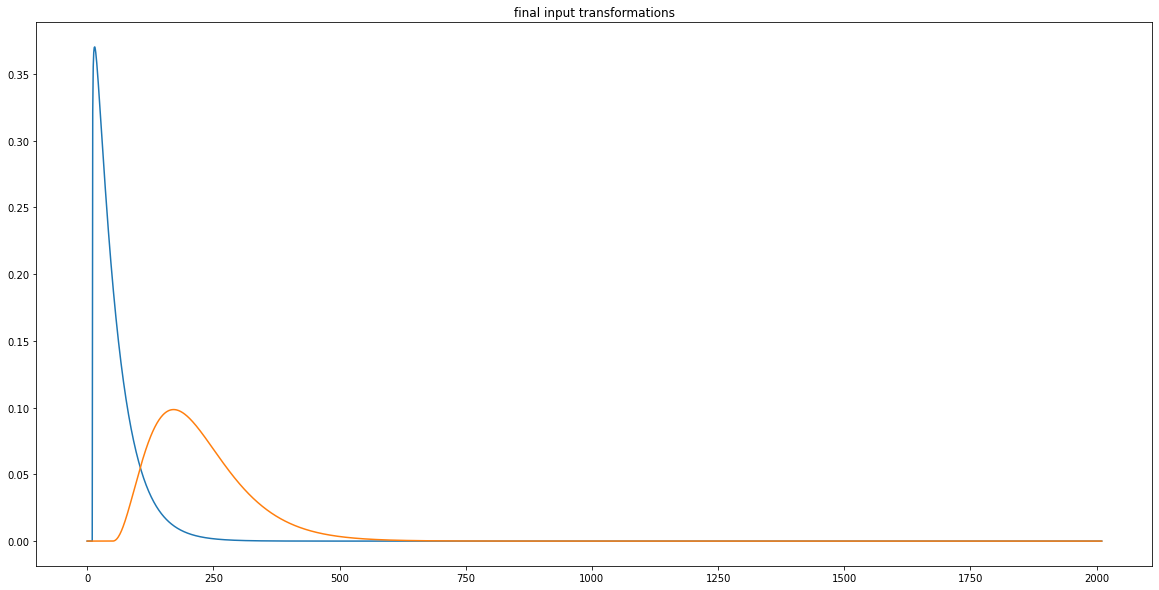

(Q)' = -0.00124 Q + 2.31556 P-Trans-1 + -1.26534 P-Trans-2
score =  0.9748190100224464


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


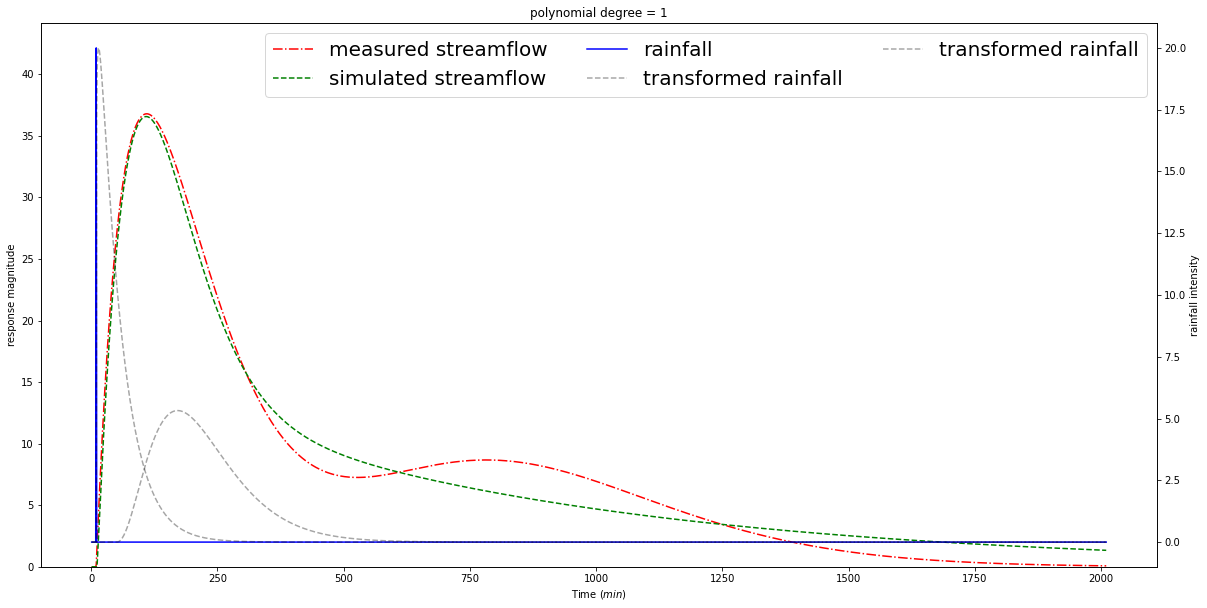

Simulation MAE =  1.3348590922180132
Simulation RMSE =  1.5092588741864654
[11.]

Initial model:

score
0.2909522707521295
shape factors
[11.]
scale factors
[1.]
location factors
[1.]

[11.]
[2222.]
[11.]
[11.]
[2222.]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, -9.009022372552522e-08, 0.0, 0.0007645232543080915, -2.6244480522130686e-07, 0.0, 0.038743037456490104, 0.0254273548114351, 0.0]
speed
50
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
0


[11.]
[555.5]
[11.]
[11.]
[555.5]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.2909522707521295, 8.631454986052223e-05, 0.0, 0.005957696743443375, 0.02900603663343504, 0.0, 0.18715028573155335, 0.03592172641410163, 0.0]
speed
10
shape factors
[11.]
scale factors
[1.]
location factors
[1.]
iteration no:
1


[11.]
[111.1]
[1.1]
[11.]
[11.]
[111.1]
[1.1]
[1.1]
[11.11]
[1.1]
[1.1]
[11.11]
[1.1]
[11.11]
[1.1]
[1.

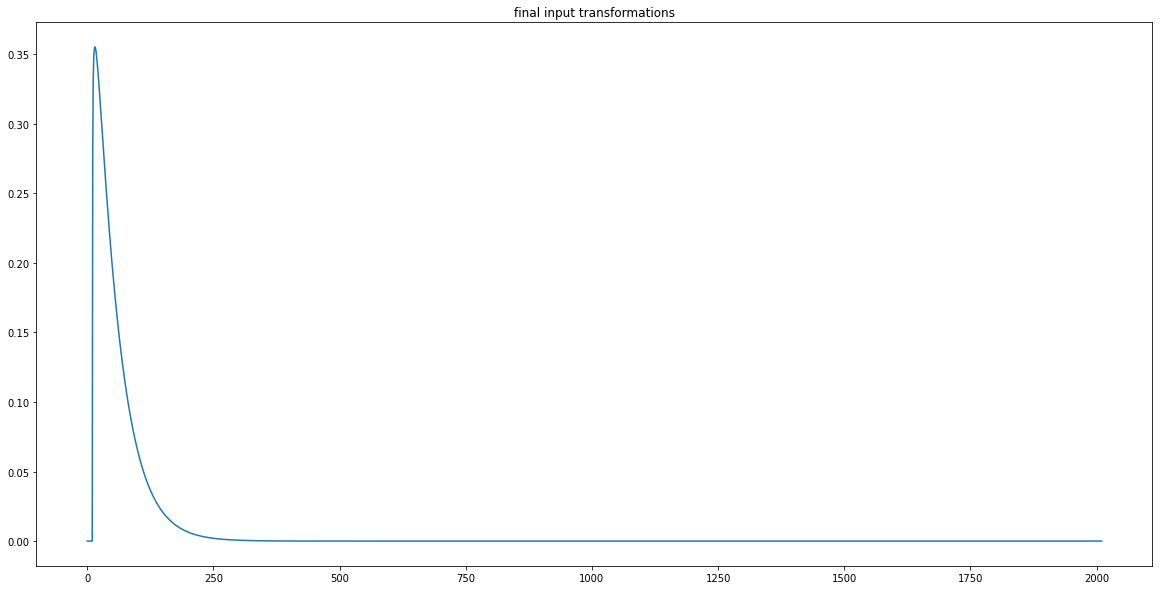

(Q)' = -0.00388 Q + 2.54608 P-Trans-1
score =  0.9499961431349364


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


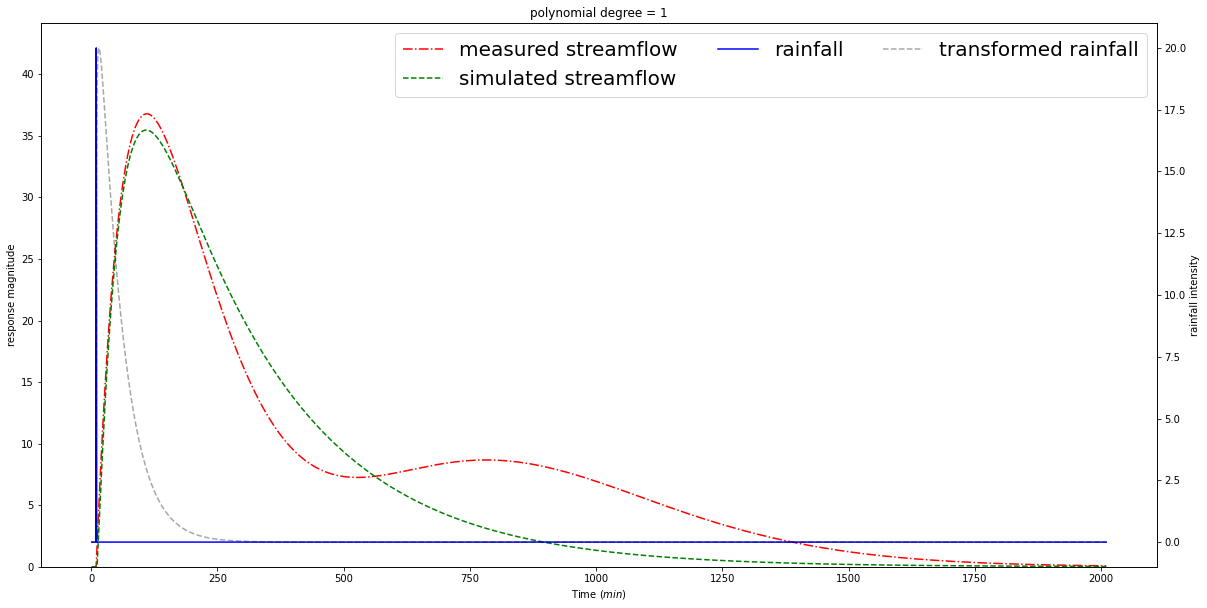

Simulation MAE =  2.471760816231067
Simulation RMSE =  3.181484668025565
[ 1.10878133 17.        ]

Initial model:

score
0.9506880796395217
shape factors
[ 1.10878133 17.        ]
scale factors
[41.82823634  1.        ]
location factors
[0.8212221 1.       ]

[ 1.10878133 17.        ]
[1.10878133e+00 3.43400000e+03]
[ 1.10878133 17.        ]
[ 1.10878133 17.        ]
[1.10878133e+00 3.43400000e+03]
[ 1.10878133 17.        ]
[223.97382837  17.        ]
[ 1.10878133 17.        ]
[ 1.10878133 17.        ]
[223.97382837  17.        ]

previous, shape up, shape down, scale up, scale down, sooner, later, rounder, sharper
[0.9506880796395217, 0.28428699199313034, 0.0, 0.2867538929947725, 0.3037979838225281, 0.0, 0.39418308798392976, 0.3404860597215167, 0.0]
speed
50
shape factors
[ 1.10878133 17.        ]
scale factors
[41.82823634  1.        ]
location factors
[0.8212221 1.       ]
iteration no:
1


[ 1.10878133 17.        ]
[  1.10878133 858.5       ]
[ 1.10878133 17.        ]
[ 1.10878133

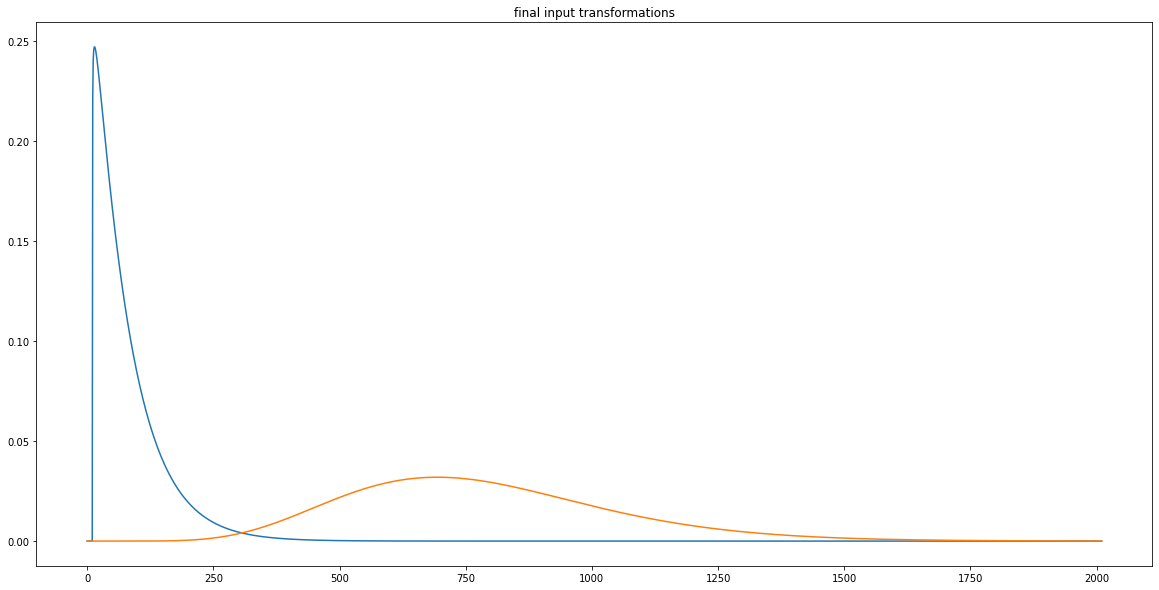

(Q)' = -0.00722 Q + 3.64255 P-Trans-1 + 2.08829 P-Trans-2
score =  0.9832838628698337


/usr/local/lib/python3.8/dist-packages/pysindy/pysindy.py:872: UserWarning: Last time point dropped in simulation because interpolation of control input was used. To avoid this, pass in a callable for u.
  warnings.warn(


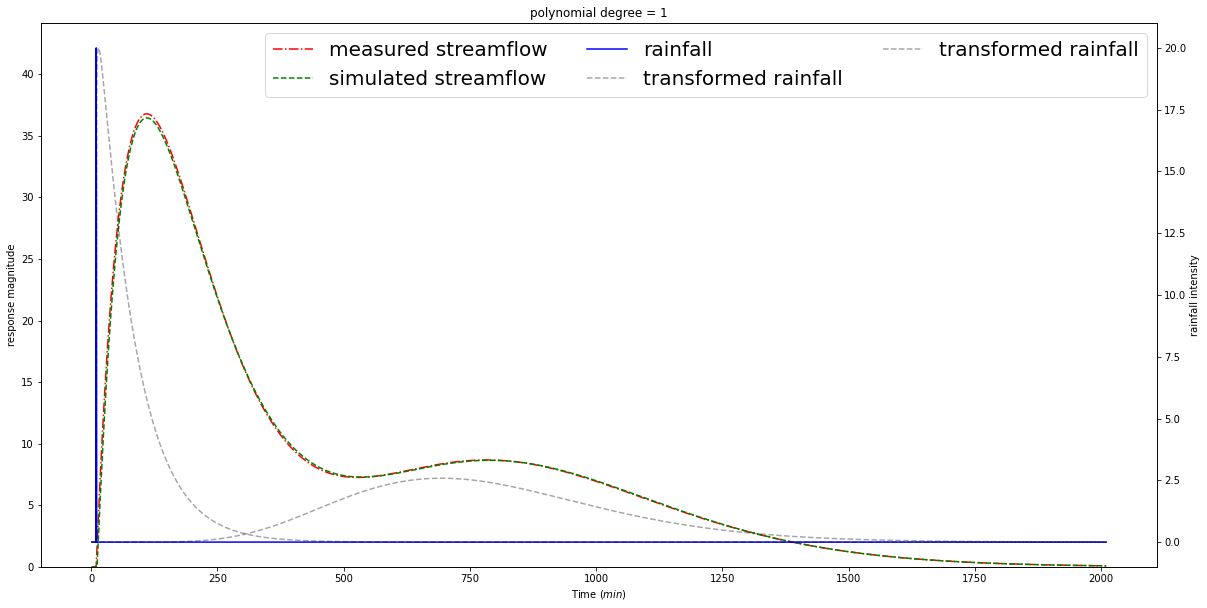

Simulation MAE =  0.09482468048392446
Simulation RMSE =  0.244303476058104


In [11]:
### batched version
# iter: 1, num_lines: 1
# iter: 25, num_lines: 1
# iter:10, num_lines: 2
# iter:40, num_lines:2

iterations_per_line = np.array([1,25,10,40])
num_lines = np.array([1,1,2,2])
best_models = list()
for idx in range(0,4):
  best_models.append(optimize_lag_shapes(1,1,1,num_lines[idx]+1,X,iterations_per_line[idx]))




In [12]:
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

best_models[0][0][1].print(precision=4)
title = new_stdout.getvalue().rstrip()
sys.stdout = old_stdout


title = ' | '.join([title , "R^2 = {score:.3f}".format(score=best_model[0][0]) ])

time = best_models[0][0][-5]
actual_rainfall = best_models[0][0][-2]
transformed_rainfall = best_models[0][0][-1]
modeled_streamflow = best_models[0][0][-4]


for idx in range(1, len(best_models[0][0][1].coefficients()[0])):

  transformed_rainfall[:,idx-1] = transformed_rainfall[:,idx-1]  / np.max(transformed_rainfall[:,idx-1]) # magnitude of 1

scaled_response = response.outputs[:]

# figure v1

In [13]:
'''



l4 = ax1.plot(scaled_response[7][:]/np.max(scaled_response[7][:]),'b',label='Reservoir 1',alpha=0.7,linewidth=10)
l5 = ax1.plot(scaled_response[8][:]/np.max(scaled_response[8][:]),'orange',label='Reservoir 2',alpha=0.7,linewidth=10)
l6 = ax1.plot(scaled_response[9][:]/np.max(scaled_response[9][:]), 'r-', label='Synthetic Streamflow',alpha=0.7,linewidth=10)

l1 = ax1.plot(time,transformed_rainfall[1:,0], 'k-.', label='Approximate Reservoir 1',linewidth=5)
l3 = ax1.plot(time,modeled_streamflow / np.max(scaled_response[9][:]),'g-.',label='Modeled Streamflow',linewidth=5)

if (num_lines > 1):
  l2 = ax1.plot(time,transformed_rainfall[1:,1], 'k-.', label='Approximate Reservoir 2',linewidth=5)
  lns = l1+l2+l3+l4+l5+l6
else:
  lns = l1+l3+l4+l5+l6

labs = [l.get_label() for l in lns]

ax1.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False,
    left=False) # labels along the bottom edge are off



plt.title(title,fontsize=50)
if (iterations_per_line < 5 and num_lines < 2): # first line, first guess
  plt.suptitle('Iteration #%d' % iterations_per_line, fontsize=45, y =.91)
elif (iterations_per_line > 5 and num_lines < 2): # first line takes 25 iterations to converge
  plt.suptitle('Iteration #%d' % iterations_per_line, fontsize=45, y =.91)
else:
  plt.suptitle('Iteration #%d' % (iterations_per_line+25), fontsize=45, y=.91)

if (iterations_per_line > 26): # only on last plot
  plt.legend(lns, labs, loc=0,fontsize=40)

plt.tight_layout()
'''

"\n\n\n\nl4 = ax1.plot(scaled_response[7][:]/np.max(scaled_response[7][:]),'b',label='Reservoir 1',alpha=0.7,linewidth=10)\nl5 = ax1.plot(scaled_response[8][:]/np.max(scaled_response[8][:]),'orange',label='Reservoir 2',alpha=0.7,linewidth=10)\nl6 = ax1.plot(scaled_response[9][:]/np.max(scaled_response[9][:]), 'r-', label='Synthetic Streamflow',alpha=0.7,linewidth=10)\n\nl1 = ax1.plot(time,transformed_rainfall[1:,0], 'k-.', label='Approximate Reservoir 1',linewidth=5)\nl3 = ax1.plot(time,modeled_streamflow / np.max(scaled_response[9][:]),'g-.',label='Modeled Streamflow',linewidth=5)\n\nif (num_lines > 1):\n  l2 = ax1.plot(time,transformed_rainfall[1:,1], 'k-.', label='Approximate Reservoir 2',linewidth=5)\n  lns = l1+l2+l3+l4+l5+l6\nelse:\n  lns = l1+l3+l4+l5+l6\n\nlabs = [l.get_label() for l in lns]\n\nax1.tick_params(\n    axis='both',          # changes apply to the x-axis\n    which='both',      # both major and minor ticks are affected\n    bottom=False,      # ticks along the bott

# 4x3 version

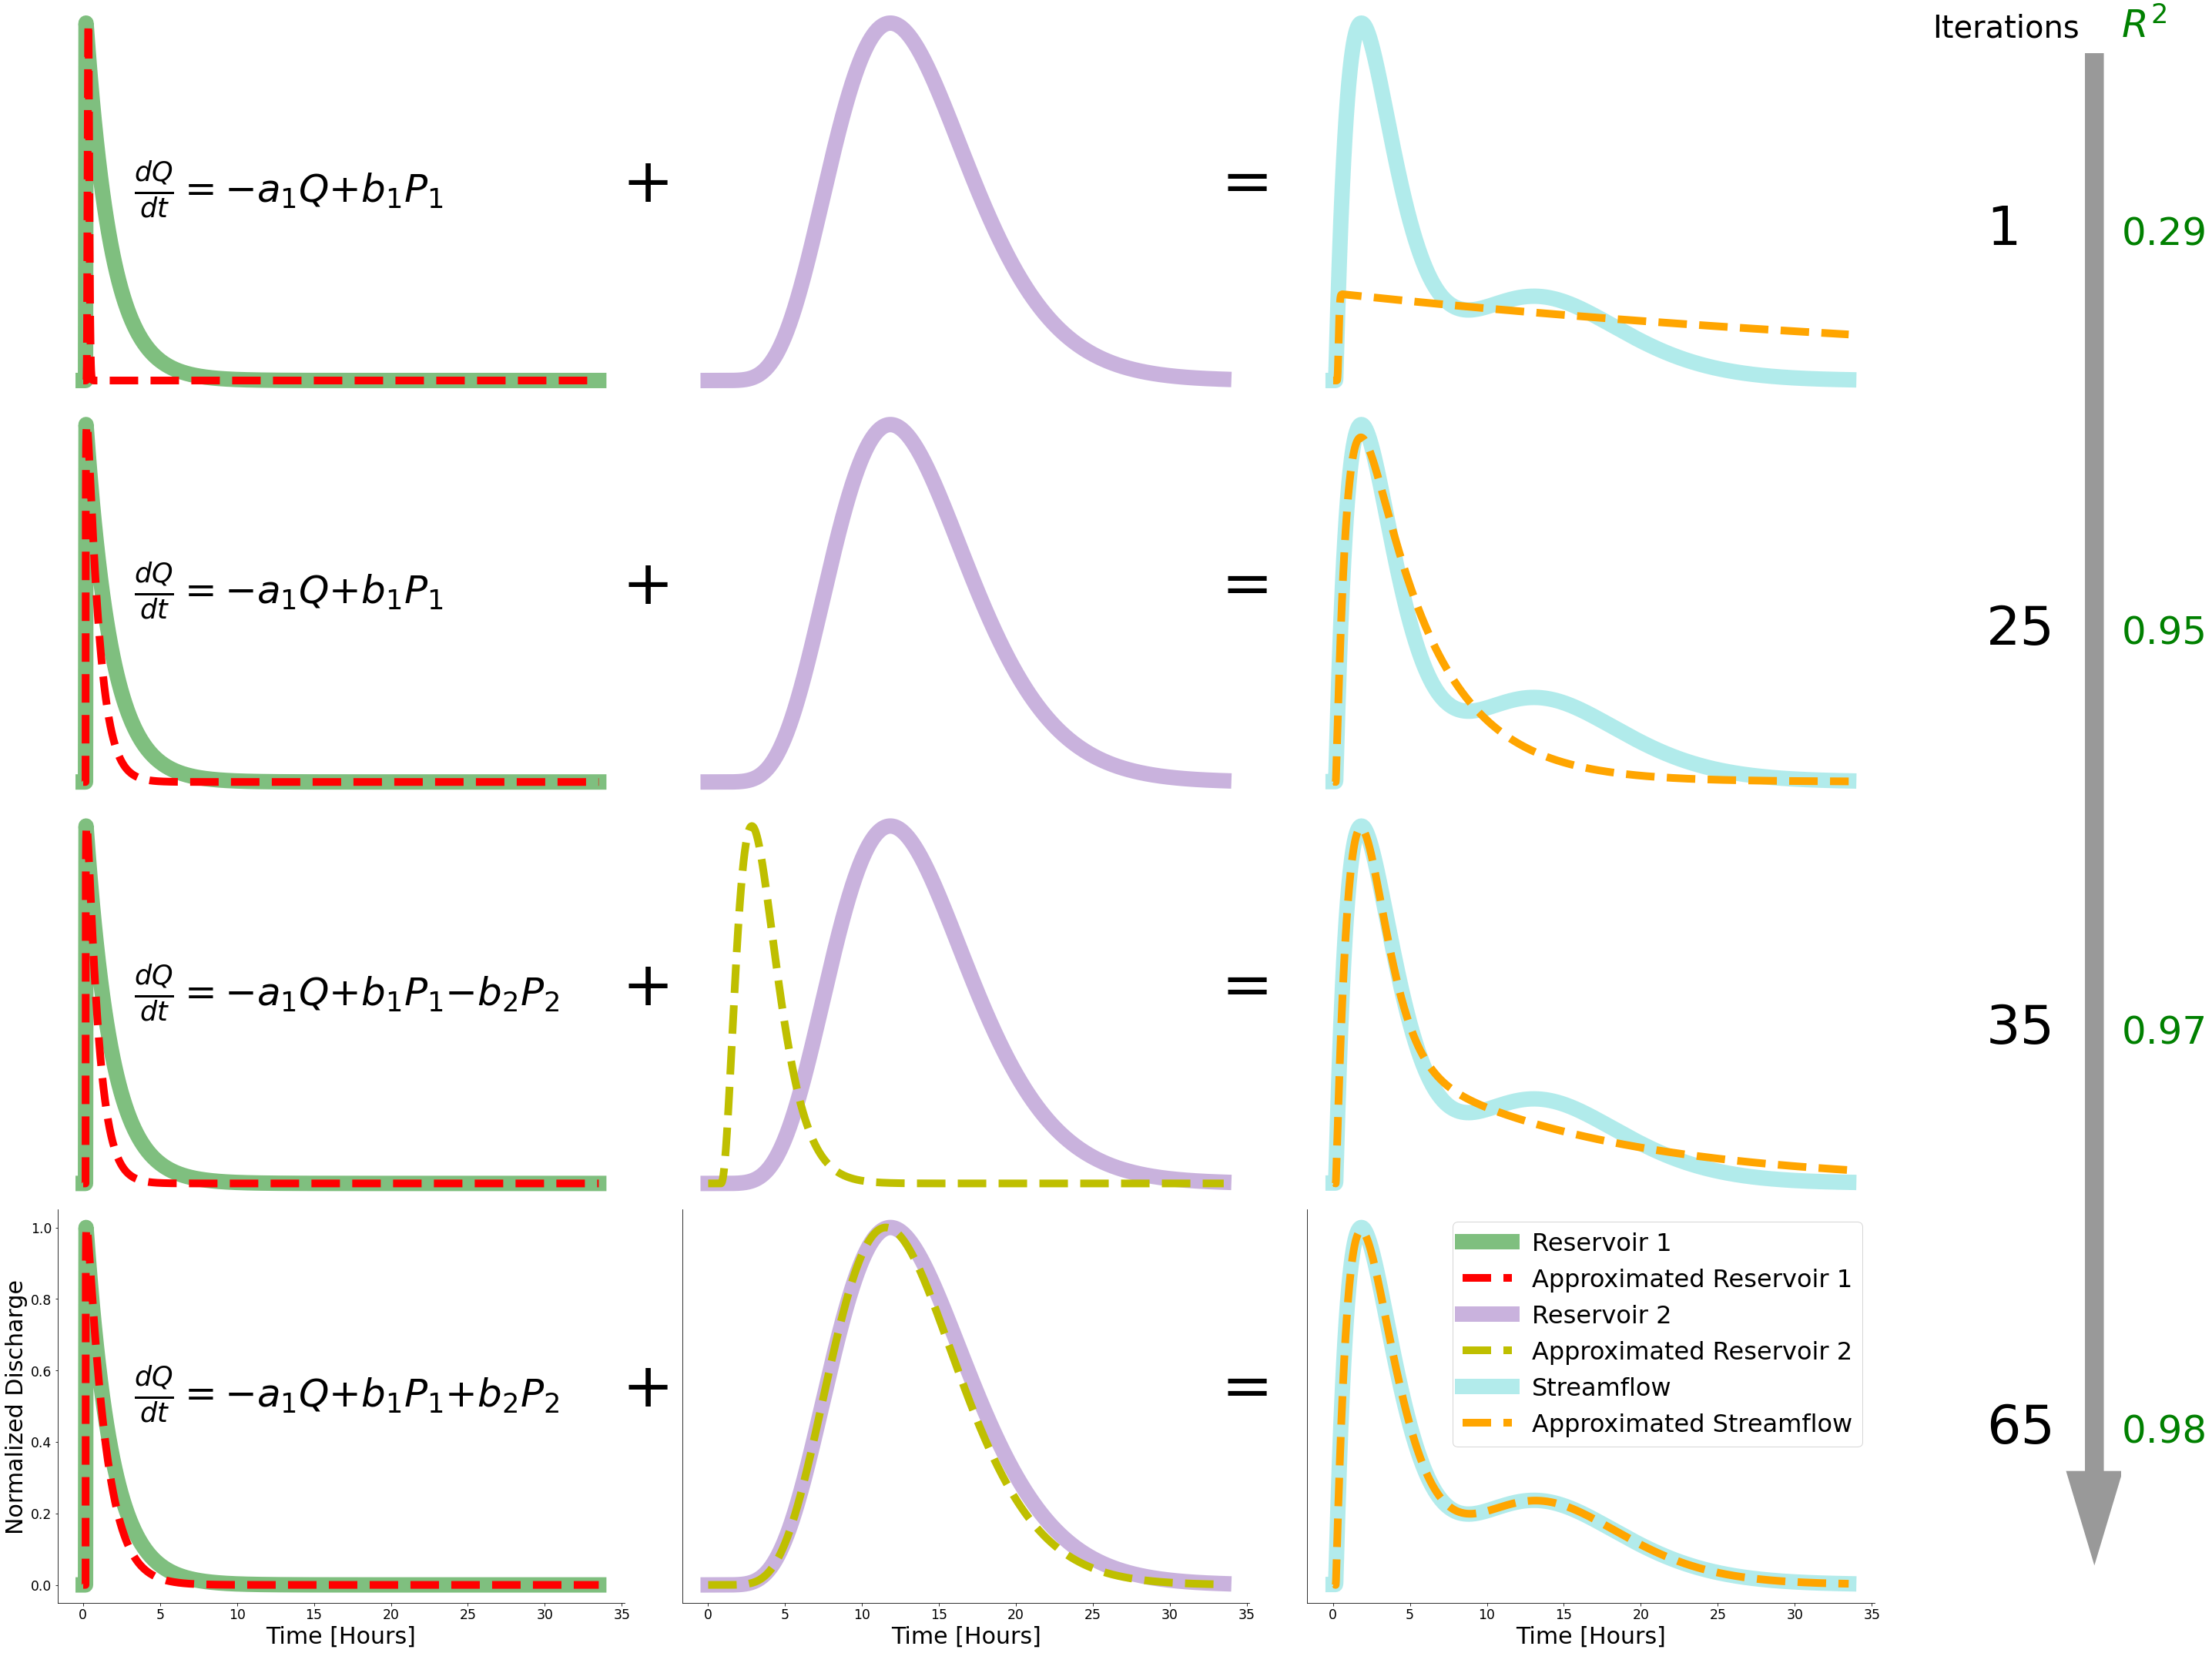

In [15]:
fig = plt.figure(figsize=(40,30))

gs = GridSpec(4,4,figure=fig,width_ratios=[3,3,3,1])

for row in range(0,4):

  # get equation
  coefficient_positive = best_models[row][0][1].coefficients()[0][:] > 0


  equation = r"$\frac{dQ}{dt} = $"
  if (coefficient_positive[0]):
    equation = equation + r"$a_1 Q$"
  else:
    equation = equation + r"$-a_1 Q$"

  if (coefficient_positive[1]):
    equation = equation + r"$ + b_1 P_1$"
  else:
    equation = equation + r"$ - b_1 P_1$"

  if (len(coefficient_positive) > 2 and coefficient_positive[2]):
    equation = equation + r"$ + b_2 P_2$"
  elif(len(coefficient_positive) > 2):
    equation = equation+r"$ - b_2 P_2$"
  

  time = best_models[row][0][-5] / 60
  actual_rainfall = best_models[row][0][-2]
  transformed_rainfall = best_models[row][0][-1]
  modeled_streamflow = best_models[row][0][-4]


  for idx in range(1, len(best_models[row][0][1].coefficients()[0])):

    transformed_rainfall[:,idx-1] = transformed_rainfall[:,idx-1]  / np.max(transformed_rainfall[:,idx-1]) # magnitude of 1

  scaled_response = response.outputs[:]

  line1 = fig.add_subplot(gs[row,0])
  r1 = line1.plot(time,scaled_response[8][:-1]/np.max(scaled_response[8][:]),'g',label='Reservoir 1',alpha=0.5,linewidth=20)
  r1a = line1.plot(time,transformed_rainfall[1:,0], color = 'red',linestyle='--', label='Approximated Reservoir 1',linewidth=10)

  line1.annotate("+",(2100/60,0.5),fontsize=80)
  line1.annotate(equation, (200/60,0.5), fontsize=50)


  line2 = fig.add_subplot(gs[row,1])
  r2 = line2.plot(time,scaled_response[7][:-1]/np.max(scaled_response[7][:]),'tab:purple',label='Reservoir 2',alpha=0.5,linewidth=20)
  if (row > 1):
    r2a = line2.plot(time,transformed_rainfall[1:,1], 'y--', label='Approximated Reservoir 2',linewidth=10)
  line2.annotate("=",(2000/60,0.5),fontsize=80)


  stream = fig.add_subplot(gs[row,2])
  sts = stream.plot(time,scaled_response[9][:-1]/np.max(scaled_response[9][:]), 'c-', label='Streamflow',alpha=0.3,linewidth=20)
  stm = stream.plot(time,modeled_streamflow / np.max(scaled_response[9][:]),color='orange',linestyle='--',label='Approximated Streamflow',linewidth=10)
  
  for ax in fig.get_axes():
      ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False, labelsize='xx-large')

      ax.axis('off')

  
  if (row == 3): # only on third plot

    lns = r1 + r1a+r2+r2a+sts+stm
    labs = [l.get_label() for l in lns]
    stream.legend(lns, labs, loc=0,fontsize=32)

    line1.tick_params(bottom=True, labelbottom=True, left=True, labelleft=True, labelsize='xx-large')
    line1.axis('on')
    line1.set_ylabel("Normalized Discharge",fontsize=30)
    line1.set_xlabel("Time [Hours]",fontsize=30)
    line1.spines['right'].set_visible(False)
    line1.spines['top'].set_visible(False)

    line2.axis('on')
    line2.tick_params(bottom=True, labelbottom=True, labelsize='xx-large')
    line2.set_xlabel("Time [Hours]",fontsize=30)
    line2.spines['right'].set_visible(False)
    line2.spines['top'].set_visible(False)

    stream.axis('on')
    stream.tick_params(bottom=True,labelbottom=True, labelsize='xx-large')
    stream.set_xlabel("Time [Hours]",fontsize=30)
    stream.spines['right'].set_visible(False)
    stream.spines['top'].set_visible(False)




iter_ax = fig.add_subplot(gs[:,3])
iter_ax.quiver(0,0.47, 0,-1, scale=0.125, width = 0.1, headwidth = 3, headlength=5, headaxislength=5, alpha = 0.4)
iter_ax.axis('off')
iter_ax.set_ylim([-0.5,0.5])
iter_ax.set_xlim([-0.6,0.1])


iter_ax.annotate("Iterations", (-0.6,0.48),fontsize=40,color='k')
iter_ax.annotate(r"$R^2$",(0.1, 0.48),fontsize=50,color='g')

iter_ax.annotate("1", (-0.4, 0.35), fontsize=70, color='k')
iter_ax.annotate("{score:.2f}".format(score=best_models[0][0][0])  , (0.1, 0.35) , fontsize=50, color='g')

iter_ax.annotate("25", (-0.4, 0.1), fontsize=70, color='k')
iter_ax.annotate("{score:.2f}".format(score=best_models[1][0][0])  , (0.1, 0.1) , fontsize=50, color='g')

iter_ax.annotate("35", (-0.4, -0.15), fontsize=70, color='k')
iter_ax.annotate("{score:.2f}".format(score=best_models[2][0][0])  , (0.1, -0.15) , fontsize=50, color='g')

iter_ax.annotate("65", (-0.4, -0.4), fontsize=70, color='k')
iter_ax.annotate("{score:.2f}".format(score=best_models[3][0][0])  , (0.1, -0.4) , fontsize=50, color='g')

plt.tight_layout()    


plt.savefig(fname='/content/drive/MyDrive/PhD Admin and Notes/paper1/figure3.svg',bbox_inches='tight',transparent=True)
